# **Verifying Implementation : AOD-Net + YOLOv5**

## In this notebook, we run [AOD-Net](https://github.com/walsvid/AOD-Net-PyTorch) and [YOLOv5](https://pytorch.org/hub/ultralytics_yolov5/).


Note : To be able to run this colab you have to follow the steps below,


*   Clone the github repo
*   Upload it on Google Drive
*   Mount the Goolge drive 
*   Run the code  

This is required to be done because the code requires a CUDA device which is available in Google Colab.


In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


Move to the directory where the github repo clone is uploaded

In [2]:
# %cd /gdrive/MyDrive/PMLProject/PyTorch-Image-Dehazing-master 

/gdrive/MyDrive/PMLProject


Once we are in the project directory of this [git repo](https://github.com/MayankSingal/PyTorch-Image-Dehazing)

Running Inference on images from [RTTS dataset](https://sites.google.com/view/reside-dehaze-datasets/reside-%CE%B2)

In [48]:
!python dehaze.py

test_images/BD_Baidu_050.png done!
test_images/BD_Baidu_058.png done!


In [18]:
import matplotlib.pyplot as plt
from matplotlib import image as mpimg

## Visualise the input and output from the AOD-Net

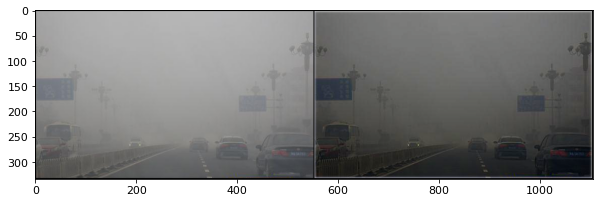

In [49]:
plt.figure(figsize=(10, 10))
image2 = mpimg.imread("results/BD_Baidu_058.png")
plt.imshow(image2)
plt.show()


# Obtaining the YOLOv5 Model

In [23]:
import torch

# Model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)


/usr/local/lib/python3.7/dist-packages/torch/hub.py:267: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  "You are about to download and run code from an untrusted repository. In a future release, this won't "
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
requirements: YOLOv5 requirements "gitpython" "ipython" not found, attempting AutoUpdate...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.de

  0%|          | 0.00/14.1M [00:00<?, ?B/s]


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 
image 1/1: 372x838 14 cars
Speed: 32.2ms pre-process, 908.4ms inference, 16.9ms NMS per image at shape (1, 3, 288, 640)


In [66]:
import torchvision.transforms.functional as F
import numpy as np

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False,figsize=(20,20))
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [50]:

# Images
imgs = ['results/BD_Baidu_058.png']  # batch of images

# Inference
results = model(imgs)

# Results
results.print()

image 1/1: 334x1106 10 cars, 1 truck
Speed: 51.2ms pre-process, 32.8ms inference, 2.1ms NMS per image at shape (1, 3, 224, 640)


The bounding box and confidence and detected class are returned by the YOLO network for each recognised instance in the image

In [51]:
results.pandas().xyxy[0]

,xmin,ymin,xmax,ymax,confidence,class,name
0,987.525879,240.333252,1104.681885,326.898621,0.886229,2,car
1,436.623962,239.794540,554.216736,329.240448,0.850263,2,car
2,911.739929,249.265839,976.965881,296.010956,0.821331,2,car
3,360.369110,247.920593,424.245087,295.618378,0.761139,2,car
4,856.928711,250.930893,896.120361,286.514832,0.742636,2,car
5,305.104828,251.169205,345.717438,287.934174,0.563007,2,car
6,737.698975,253.360748,765.863525,270.655914,0.440558,2,car
7,560.085999,223.967438,641.221497,294.002167,0.419755,2,car
8,129.639771,269.005157,360.428345,331.248138,0.364728,2,car
9,187.247818,254.448837,213.265182,270.868347,0.328707,2,car


In [56]:
from PIL import Image
import torchvision.transforms as transforms

image = Image.open('results/BD_Baidu_058.png')
  
# Define a transform to convert PIL 
# image to a Torch tensor
transform = transforms.Compose([
    transforms.PILToTensor()
])
  
# transform = transforms.PILToTensor()
# Convert the PIL image to Torch tensor
img_tensor = transform(image)

In [64]:

#boxes=[(xmin, ymin, xmax, ymax)]
bb_labels=[]
xmin=results.pandas().xyxy[0]['xmin']
ymin=results.pandas().xyxy[0]['ymin']
xmax=results.pandas().xyxy[0]['xmax']
ymax=results.pandas().xyxy[0]['ymax']
confid=results.pandas().xyxy[0]['confidence']
class_name=results.pandas().xyxy[0]['name']
boxes=list(zip(xmin,ymin,xmax,ymax))
bb_labels=list(zip(class_name,confid))
bb_labels=[str(x[0])+'_'+str(round(x[1],2)) for x in bb_labels]

## Observing the bounding box outcome before and after hazing

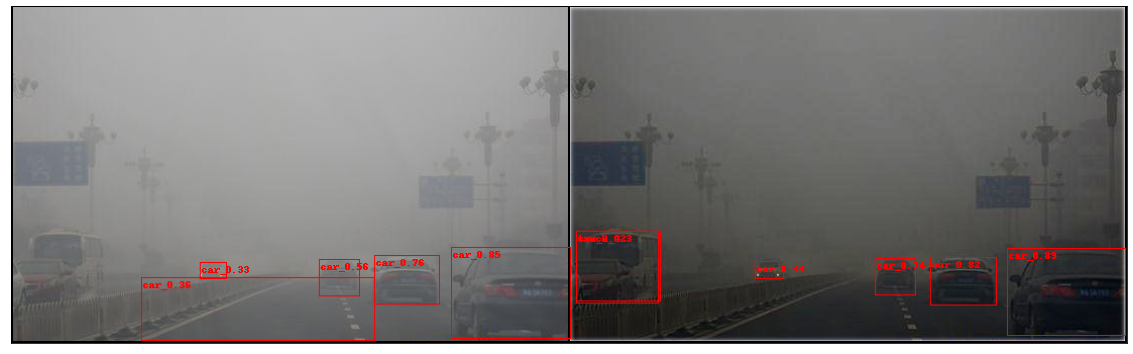

In [67]:
from torchvision.utils import draw_bounding_boxes

drawn_boxes = draw_bounding_boxes(img_tensor, torch.FloatTensor(boxes),labels=bb_labels,colors="red")
show(drawn_boxes)

## Visually the bounding boxes improve after dehazing with AOD-Net, though to the human eye the picture may still appears hazy